In [12]:
import numpy as np
from EnergyDataset import EnergyDataset

In [13]:
all_data = np.load(r"E:\datasets\dampe\selected_data.npz")
X_tr, X_te, y_tr, y_te, t_tr, t_te = all_data["X_tr"], all_data["X_te"], all_data["y_tr"], all_data["y_te"], all_data["t_tr"], all_data["t_te"]
print(f'X_tr shape: {X_tr.shape}, X_te shape: {X_te.shape}, y_tr shape: {y_tr.shape}, y_te shape: {y_te.shape}, t_tr shape: {t_tr.shape}, t_te shape: {t_te.shape}')

X_tr shape: (115566, 1, 14, 22), X_te shape: (49529, 1, 14, 22), y_tr shape: (115566,), y_te shape: (49529,), t_tr shape: (115566,), t_te shape: (49529,)


In [14]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
val_ds = EnergyDataset(X_te, y_te, t_te)
test_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

In [15]:
import torch
from PhysicsGuidedNet import PhysicsGuidedNet
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = PhysicsGuidedNet().to(DEVICE)
model.load_state_dict(torch.load("./checkpoints/best_model.pth", map_location=DEVICE))
print(model)

PhysicsGuidedNet(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=962, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [16]:
model.eval()
# 进行推理
predictions = []
true_values = []
with torch.no_grad():
    for img, label, dense in test_loader:
        img, dense = img.to(DEVICE), dense.to(DEVICE)
        pred = model(img, dense)
        pred = torch.relu(pred)  # 确保预测值为正
        
        predictions.extend(pred.cpu().numpy())
        true_values.extend(label.numpy())

predictions = np.array(predictions)
true_values = np.array(true_values)
print(f'predictions shape: {predictions.shape}, true_values shape: {true_values.shape}')

predictions shape: (49529,), true_values shape: (49529,)


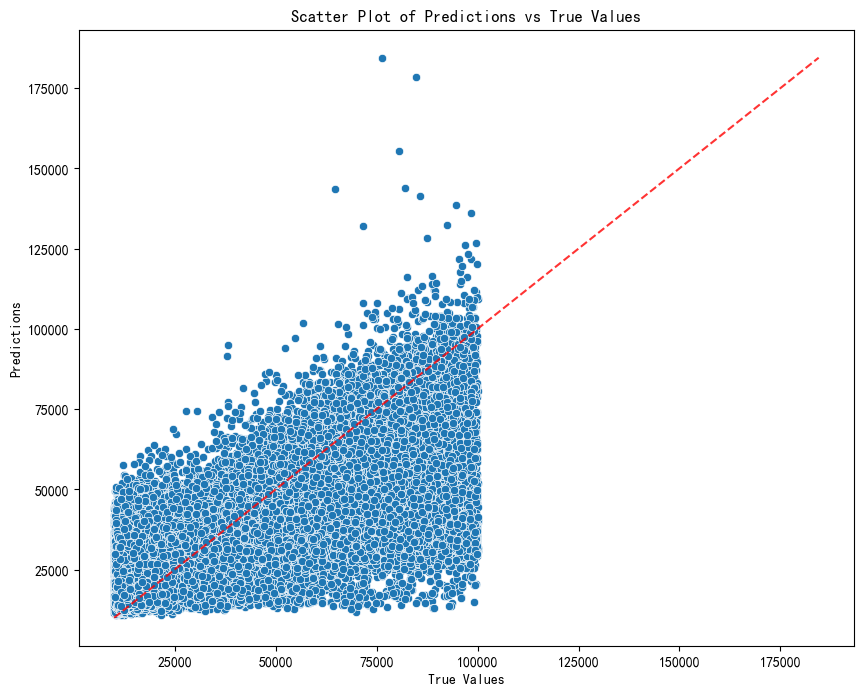

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# 绘制预测结果的散点图
plt.figure(figsize=(10, 8))
sns.scatterplot(x=true_values, y=predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Scatter Plot of Predictions vs True Values')

# 添加对角线，表示完美预测
min_val = min(min(true_values), min(predictions))
max_val = max(max(true_values), max(predictions))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)

plt.show()

In [18]:
import pandas as pd

results = pd.DataFrame({'True Values': true_values, 'Predictions': predictions, 'Error': abs(true_values - predictions)})
print(results.head())

    True Values   Predictions         Error
0  17401.400391  14754.548828   2646.851562
1  80685.398438  44866.699219  35818.699219
2  61156.300781  33099.582031  28056.718750
3  23170.300781  33747.160156  10576.859375
4  40566.601562  43301.808594   2735.207031


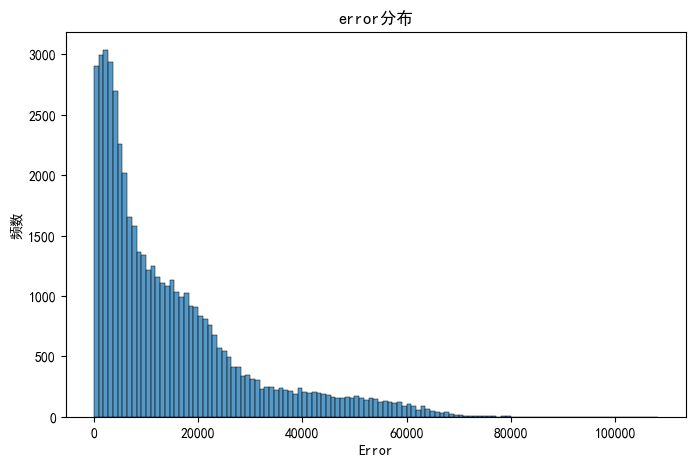

In [19]:
plt.rcParams['font.sans-serif'] = ['SimHei']   # 用黑体显示中文
plt.rcParams['axes.unicode_minus'] = False    # 解决负号'-'显示成方块的问题

plt.figure(figsize=(8, 5))
sns.histplot(data=results, x="Error")
plt.title("error分布")
plt.xlabel("Error")
plt.ylabel("频数")
plt.show()

In [20]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    r2_score
)

mae = mean_absolute_error(true_values, predictions)
mse = mean_squared_error(true_values, predictions)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(true_values, predictions)
r2 = r2_score(true_values, predictions)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("MAPE:", mape)
print("R2:", r2)

MAE: 14719.3857421875
MSE: 428393024.0
RMSE: 20697.657451992
MAPE: 0.4487277865409851
R2: 0.3304969072341919


In [37]:
error_25 = results.query("Error >= 25000")
print(error_25.head())
error_25.shape

     True Values   Predictions         Error
1   80685.398438  44866.699219  35818.699219
2   61156.300781  33099.582031  28056.718750
6   93060.000000  25202.291016  67857.710938
9   85158.398438  37916.191406  47242.207031
15  83720.601562  49408.125000  34312.476562


(8988, 3)

In [34]:
error_25_ids = error_25.index.tolist()
print(f'len error_25_ids: {len(error_25_ids)}')
error_25_x = X_te[error_25_ids]
error_25_y = y_te[error_25_ids]
error_25_theta = t_te[error_25_ids]
error_25_p = predictions[error_25_ids]
print(f'error_25_x shape: {error_25_x.shape}, error_25_y shape: {error_25_y.shape}, error_25_theta shape: {error_25_theta.shape}')

len error_25_ids: 8988
error_25_x shape: (8988, 1, 14, 22), error_25_y shape: (8988,), error_25_theta shape: (8988,)


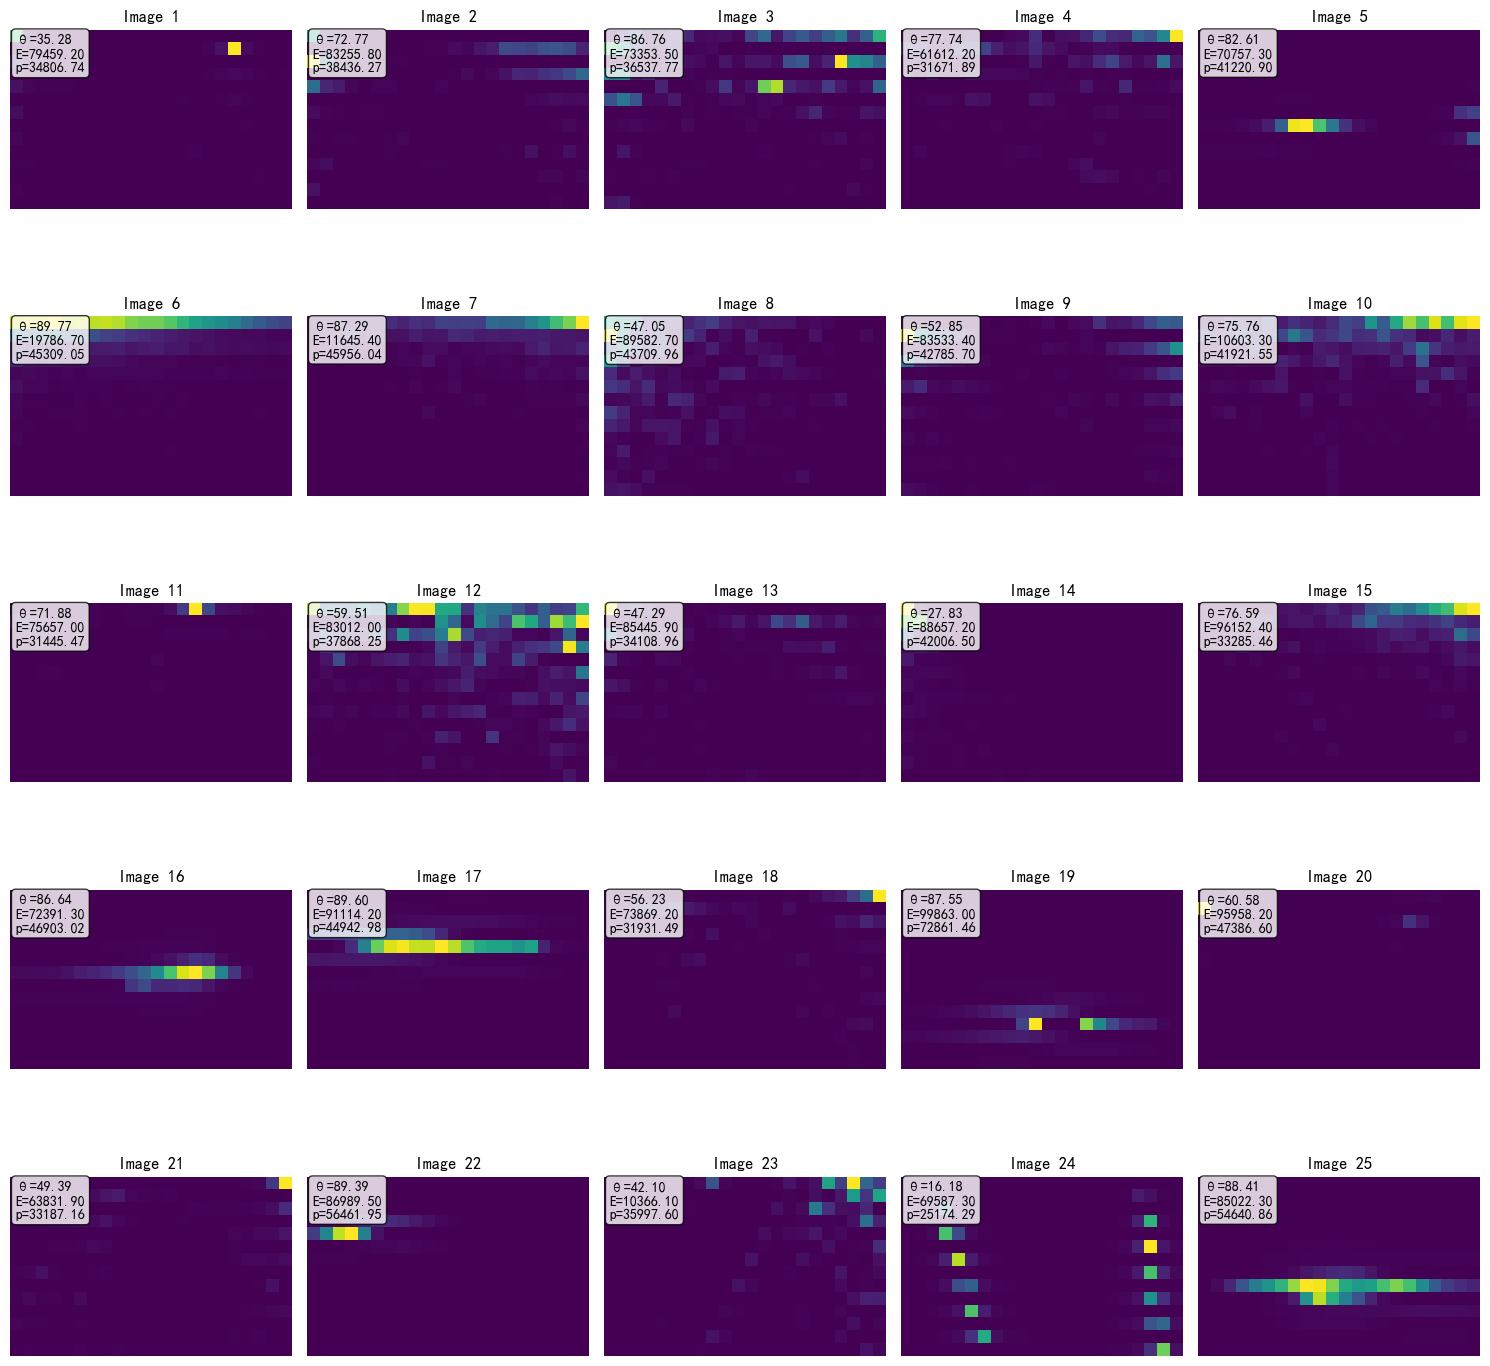

In [36]:
l = 100
xx = error_25_x[l: l+25]
yy = error_25_y[l: l+25]
tt = error_25_theta[l: l+25]
pp = error_25_p[l: l+25]

fig, axes = plt.subplots(5, 5, figsize=(15, 15))
for i in range(25):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(xx[i].squeeze(), cmap='viridis')

    axes[row, col].text(0.02, 0.98, f'θ={tt[i]:.2f}\nE={yy[i]:.2f}\np={pp[i]:.2f}',
                        transform=axes[row, col].transAxes,
                        verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    axes[row, col].set_title(f'Image {i + 1}')
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()

In [38]:
from scipy import stats

# 计算 Pearson 相关性和 P值
corr_p, p_value_p = stats.pearsonr(error_25_theta, error_25['Error'])
print(f"Pearson r={corr_p:.4f}, p-value={p_value_p:.4e}")
# 0：无线性相关（但不代表没关系，可能是曲线关系）。

Pearson r=0.0012, p-value=9.1259e-01
